In [1]:
# Import `numpy` under the alias `np`
import numpy as np 

# Import `pandas` under the alias `pd`
import pandas as pd 
import pmdarima as pm

import itertools #to iterate through the loops

import statsmodels.api as sm

import matplotlib.pyplot as plt 
import matplotlib as mpl
%matplotlib inline 

import plotly.express as px
import plotly.offline as py

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from pandas import Series

from datetime import datetime
from matplotlib import pyplot


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

#FBProphet related imports
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

#Importing the Auto-Arima function 
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error

 # to split the data into train and test parts
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score 


def p_mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Reading the data from a file

In [2]:
df = pd.read_excel('C:/Users/ADMIN/Desktop/capstone project/Sales Forecast_Sales_Forecast_Data.xlsx')

In [3]:
df.head() # returns top n (5 by default) rows of a data frame

FIN_YEAR MONTH    STATE            FG DISTRICT  COMPANY    VALUE
0  2014-2015   Nov  Haryana  Insecticides   Rohtak  monous    675.00
1  2014-2015   Nov  Haryana  Insecticides   Rewari  monous     73.71
2  2014-2015   Nov  Haryana  Insecticides  Gurgaon  monous    405.00
3  2014-2015   Nov  Haryana  Insecticides    Mewat  monous   1188.00
4  2014-2015   Nov  Haryana  Insecticides   Palwal  monous   5188.59

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230152 entries, 0 to 230151
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   FIN_YEAR  230152 non-null  object 
 1   MONTH     230152 non-null  object 
 2   STATE     230152 non-null  object 
 3   FG        230152 non-null  object 
 4   DISTRICT  230152 non-null  object 
 5   COMPANY   230152 non-null  object 
 6   VALUE     230152 non-null  float64
dtypes: float64(1), object(6)
memory usage: 12.3+ MB


# Data Preparation for modelling : using ABC Manufacturing data only

In [5]:
#Constants used within this file
train_start_date = '2014-01-01'
train_end_date = '2016-12-01'
test_start_date = '2017-01-01'
test_end_date = '2017-12-01'
consider_rolling_window = True
consider_mean_values = False
predict_periods=12
missing_record_index = 37

In [6]:
if consider_rolling_window == True:
    rolling_period = 3
else:
    #do not change this value
    rolling_period = 1     

In [7]:
#Creating a dataframe of ABC manufacturing
ABC_df = df.loc[df['COMPANY'] == 'ABC Manufacturing']

In [8]:
#converting year range to year  . for example  "2014-2015"  will be converted to 2014 
ABC_df['FIN_YEAR'] = ABC_df.FIN_YEAR.str.slice(0,4)

#converting month to datetime for checking stationarity  
ABC_df['MONTH'] = pd.to_datetime(ABC_df['FIN_YEAR'].astype(str)+ "-"+ ABC_df['MONTH'].astype(str) + "-1")

In [9]:
ABC_df.isnull().sum() #Checking the null values in the ABC manufacturing company

FIN_YEAR    0
MONTH       0
STATE       0
FG          0
DISTRICT    0
COMPANY     0
VALUE       0
dtype: int64

In [10]:
ABC_df.isna().sum() 

FIN_YEAR    0
MONTH       0
STATE       0
FG          0
DISTRICT    0
COMPANY     0
VALUE       0
dtype: int64

In [11]:
#Considering only Haryana data for ABC manufacturing company only
ABC_df = ABC_df.loc[ (ABC_df['STATE'] == 'Haryana')]
ABC_df

FIN_YEAR      MONTH    STATE            FG      DISTRICT  \
49         2014 2014-12-01  Haryana  Insecticides        Ambala   
50         2014 2014-12-01  Haryana  Insecticides   Yamunanagar   
51         2014 2014-12-01  Haryana  Insecticides        Karnal   
52         2014 2014-12-01  Haryana  Insecticides       Panipat   
53         2014 2014-12-01  Haryana  Insecticides       Sonipat   
...         ...        ...      ...           ...           ...   
229808     2016 2016-06-01  Haryana  Bactericides   Kurukshetra   
229809     2016 2016-06-01  Haryana  Bactericides  Mahendragarh   
229815     2016 2016-12-01  Haryana  Bactericides         Mewat   
229816     2016 2016-12-01  Haryana  Bactericides         Mewat   
230015     2016 2016-09-01  Haryana  Bactericides        Karnal   

                  COMPANY      VALUE  
49      ABC Manufacturing   6019.380  
50      ABC Manufacturing    425.250  
51      ABC Manufacturing  14782.635  
52      ABC Manufacturing   4031.910  
53      ABC Manufacturing   8692.110  
...                   ...        ...  
229808  ABC Manufacturing      0.000  
229809  ABC Manufacturing      0.000  
229815  ABC Manufacturing      0.000  
229816  ABC Manufacturing      0.000  
230015  ABC Manufacturing      0.000  

[6028 rows x 7 columns]

In [12]:
ABC_df.describe()

VALUE
count   6028.000000
mean     940.150862
std     2408.979798
min        0.000000
25%        0.000000
50%       22.882500
75%      515.193750
max    26035.560000

In [13]:
ABC_df_Pesticides = ABC_df.copy(deep=True)
ABC_df_Pesticides.drop(['FIN_YEAR', 'STATE', 'FG', 'DISTRICT', 'COMPANY'],axis=1,inplace = True)

In [14]:
# Upon inspection it is found that for a period of Feb and March in 2017, there was no data. 
# We need to treat this data else seasonal_decompose() will throw error

In [15]:
# SUM 

if consider_mean_values == False:
    ABC_df_Pesticides = ABC_df_Pesticides.groupby('MONTH')['VALUE'].sum().reset_index()
    
    df1 = ABC_df_Pesticides[: missing_record_index]
    df2 = ABC_df_Pesticides[missing_record_index:]

    new_row = {'MONTH': datetime.strptime('2017-02-01', '%Y-%m-%d').date(), 'VALUE':79640.325}
    df1.loc[missing_record_index] = new_row

    new_row = {'MONTH': datetime.strptime('2017-03-01', '%Y-%m-%d').date(), 'VALUE':110978.28 }
    df1.loc[missing_record_index + 1] = new_row
                        
    ABC_df_Pesticides = pd.concat([df1, df2])                                 

In [16]:
# MEAN 

if consider_mean_values == True:
    ABC_df_Pesticides = ABC_df_Pesticides.groupby('MONTH')['VALUE'].mean().reset_index()
    
    df1 = ABC_df_Pesticides[: missing_record_index]
    df2 = ABC_df_Pesticides[missing_record_index:]

    new_row = {'MONTH': datetime.strptime('2017-02-01', '%Y-%m-%d').date(), 'VALUE':811 }
    df1.loc[missing_record_index] = new_row

    new_row = {'MONTH': datetime.strptime('2017-03-01', '%Y-%m-%d').date(), 'VALUE':1085 }
    df1.loc[missing_record_index + 1] = new_row
                        
    ABC_df_Pesticides = pd.concat([df1, df2])
    

In [17]:
ABC_df_Pesticides

MONTH       VALUE
0   2014-01-01 00:00:00  128078.820
1   2014-02-01 00:00:00  107427.060
2   2014-03-01 00:00:00  110342.925
3   2014-04-01 00:00:00   32577.660
4   2014-05-01 00:00:00   47482.740
5   2014-06-01 00:00:00  130684.185
6   2014-07-01 00:00:00   75471.075
7   2014-08-01 00:00:00  107146.530
8   2014-09-01 00:00:00  138232.710
9   2014-10-01 00:00:00  168045.030
10  2014-11-01 00:00:00  175710.870
11  2014-12-01 00:00:00  127656.945
12  2015-01-01 00:00:00   75341.880
13  2015-02-01 00:00:00   73139.760
14  2015-03-01 00:00:00  106902.720
15  2015-04-01 00:00:00  131720.580
16  2015-05-01 00:00:00  149968.395
17  2015-06-01 00:00:00  160265.790
18  2015-07-01 00:00:00  132693.660
19  2015-08-01 00:00:00  129301.785
20  2015-09-01 00:00:00  137774.115
21  2015-10-01 00:00:00  313321.500
22  2015-11-01 00:00:00  163620.135
23  2015-12-01 00:00:00  152072.100
24  2016-01-01 00:00:00   84634.065
25  2016-02-01 00:00:00   58354.155
26  2016-03-01 00:00:00  115689.195
27  2016-04-01 00:00:00   16131.285
28  2016-05-01 00:00:00   63360.630
29  2016-06-01 00:00:00  144712.575
30  2016-07-01 00:00:00  114598.395
31  2016-08-01 00:00:00  100687.320
32  2016-09-01 00:00:00  202416.975
33  2016-10-01 00:00:00  120286.890
34  2016-11-01 00:00:00  154636.020
35  2016-12-01 00:00:00  156926.565
36  2017-01-01 00:00:00  145582.245
37           2017-02-01   79640.325
38           2017-03-01  110978.280
37  2017-04-01 00:00:00   11309.085
38  2017-05-01 00:00:00  110724.975
39  2017-06-01 00:00:00  171017.595
40  2017-07-01 00:00:00   97934.940
41  2017-08-01 00:00:00   80357.130
42  2017-09-01 00:00:00   92884.995
43  2017-10-01 00:00:00  135560.655
44  2017-11-01 00:00:00  213711.210
45  2017-12-01 00:00:00  200733.525

<AxesSubplot:xlabel='MONTH', ylabel='VALUE'>

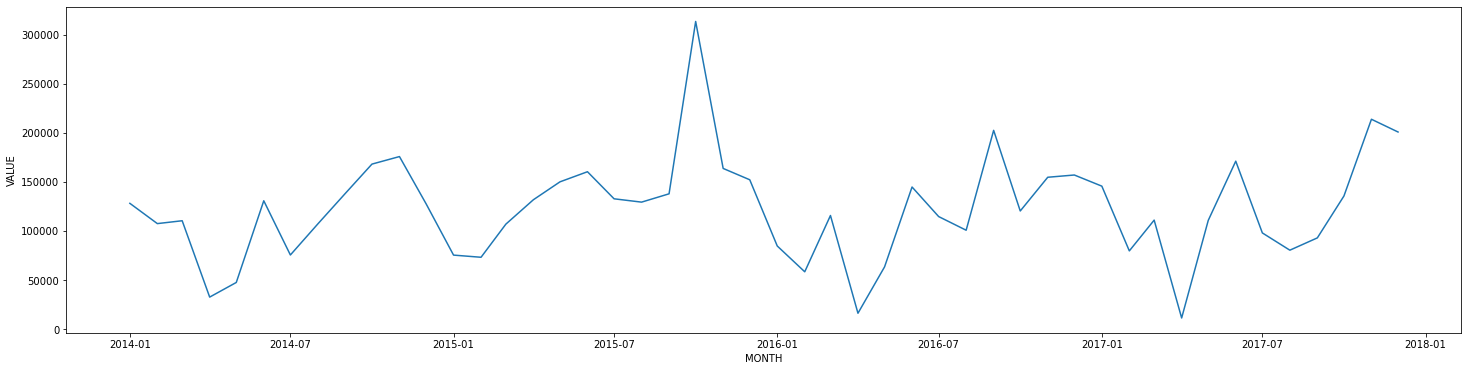

In [18]:
#Plot the data 
plt.figure(figsize=(25,6))
sns.lineplot(x="MONTH", y="VALUE", data=ABC_df_Pesticides,  ci= None)

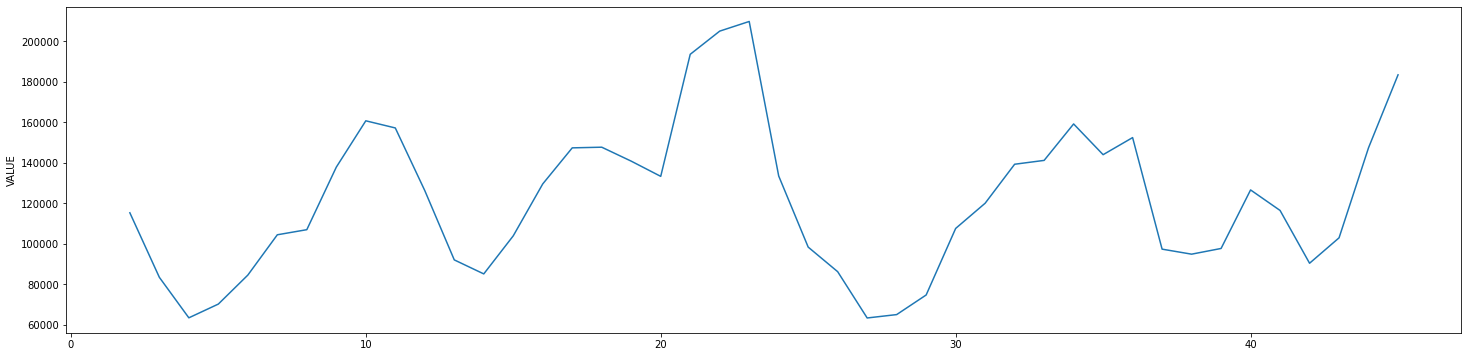

In [19]:
if consider_rolling_window == True:
    xyzseries = ABC_df_Pesticides['VALUE'].rolling(window = rolling_period)
    XYZmean = xyzseries.mean()
    plt.figure(figsize=(25,6))
    sns.lineplot( data=XYZmean,  ci= None)
    

In [20]:
XYZmean

0            NaN
1            NaN
2     115282.935
3      83449.215
4      63467.775
5      70248.195
6      84546.000
7     104433.930
8     106950.105
9     137808.090
10    160662.870
11    157137.615
12    126236.565
13     92046.195
14     85128.120
15    103921.020
16    129530.565
17    147318.255
18    147642.615
19    140753.745
20    133256.520
21    193465.800
22    204905.250
23    209671.245
24    133442.100
25     98353.440
26     86225.805
27     63391.545
28     65060.370
29     74734.830
30    107557.200
31    119999.430
32    139234.230
33    141130.395
34    159113.295
35    143949.825
36    152381.610
37    127383.045
38    112066.950
37     67309.230
38     77670.780
39     97683.885
40    126559.170
41    116436.555
42     90392.355
43    102934.260
44    147385.620
45    183335.130
Name: VALUE, dtype: float64

[Text(1, 0, 'VALUE')]

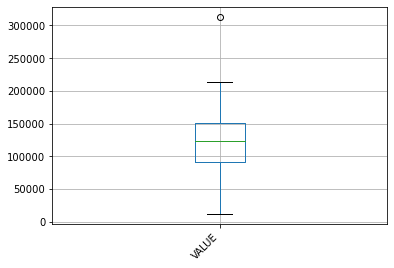

In [21]:
boxplot = ABC_df_Pesticides.boxplot(column=['VALUE'])
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45, horizontalalignment='right')

In [22]:
ABC_df_Pesticides.describe()

VALUE
count      48.000000
mean   122038.500000
std     53317.253039
min     11309.085000
25%     90822.262500
50%    123971.917500
75%    150494.321250
max    313321.500000

In [23]:
print(ABC_df_Pesticides["VALUE"].quantile(0.95))

201827.76750000007


In [24]:
#ABC_df_Pesticides["VALUE"]=np.where(ABC_df_Pesticides["VALUE"]>66082.66875,66082.66875,ABC_df_Pesticides["VALUE"])

In [25]:
if consider_rolling_window == True:
    ABC_df_Pesticides['VALUE'] = XYZmean
    ABC_df_Pesticides = ABC_df_Pesticides[rolling_period - 1:]


# Check for Stationarity and Seasonality

In [26]:
# for a time series to be Sationary
# 1. Mean has to be constant 
# 2. variance has to be constant 
# 3. No seasonality

# If a timeseries has seasonality, then it is not stationary. i.e ARMA models cannot be run.

In [27]:
# Augmented Dickey FULLER test to check Stationarity

def ADF_test(timeseries):
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [28]:
ADF_test(ABC_df_Pesticides['VALUE'])

Test statistic = -4.192
P-value = 0.001
Critical values :
	1%: -3.6055648906249997 - The data is  stationary with 99% confidence
	5%: -2.937069375 - The data is  stationary with 95% confidence
	10%: -2.606985625 - The data is  stationary with 90% confidence


In [29]:
# from the above result, as p-value < 0.05... we can conclude that the timeseries data is Stationary

In [30]:
# Additional check using KPSS method   [ Kwiatkowski–Phillips–Schmidt–Shin (KPSS)]
# Ref: https://www.statisticshowto.com/kpss-test/

stats, p, lags, critical_values = kpss(ABC_df_Pesticides['VALUE'],'c')
stats, p, lags, critical_values

print(f'Test Statistics: {stats}')
print(f'p value: {p}')
print(f'critical_values: {critical_values}')



Test Statistics: 0.1469793350568254
p value: 0.1
critical_values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


In [31]:
# as 0.1  is greater than 0.05, we can conclude that the timeseries data is Stationary

In [32]:
ABC_df_Pesticides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 2 to 45
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MONTH   46 non-null     object 
 1   VALUE   46 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB


In [33]:
# Reset index after converting 'Month' to Datetime
ABC_df_Pesticides['MONTH'] = pd.to_datetime(ABC_df_Pesticides['MONTH'])
ABC_df_Pesticides.set_index('MONTH', inplace=True)

In [34]:
ABC_df_Pesticides

VALUE
MONTH                 
2014-03-01  115282.935
2014-04-01   83449.215
2014-05-01   63467.775
2014-06-01   70248.195
2014-07-01   84546.000
2014-08-01  104433.930
2014-09-01  106950.105
2014-10-01  137808.090
2014-11-01  160662.870
2014-12-01  157137.615
2015-01-01  126236.565
2015-02-01   92046.195
2015-03-01   85128.120
2015-04-01  103921.020
2015-05-01  129530.565
2015-06-01  147318.255
2015-07-01  147642.615
2015-08-01  140753.745
2015-09-01  133256.520
2015-10-01  193465.800
2015-11-01  204905.250
2015-12-01  209671.245
2016-01-01  133442.100
2016-02-01   98353.440
2016-03-01   86225.805
2016-04-01   63391.545
2016-05-01   65060.370
2016-06-01   74734.830
2016-07-01  107557.200
2016-08-01  119999.430
2016-09-01  139234.230
2016-10-01  141130.395
2016-11-01  159113.295
2016-12-01  143949.825
2017-01-01  152381.610
2017-02-01  127383.045
2017-03-01  112066.950
2017-04-01   67309.230
2017-05-01   77670.780
2017-06-01   97683.885
2017-07-01  126559.170
2017-08-01  116436.555
2017-09-01   90392.355
2017-10-01  102934.260
2017-11-01  147385.620
2017-12-01  183335.130

<AxesSubplot:xlabel='MONTH'>

<Figure size 2160x2520 with 0 Axes>

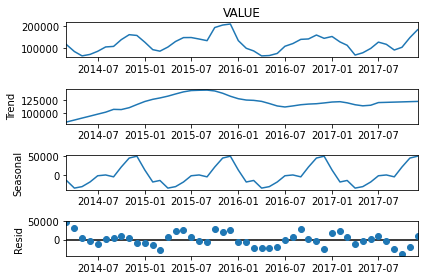

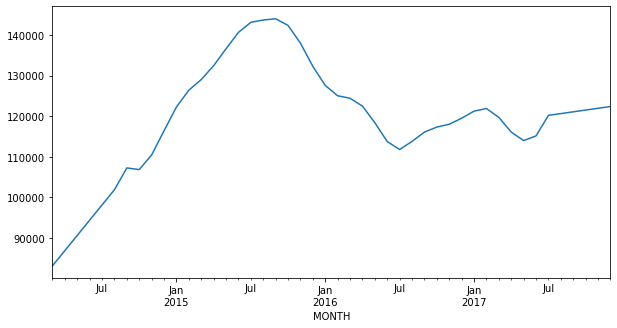

In [35]:
res = sm.tsa.seasonal_decompose(ABC_df_Pesticides['VALUE'],model = 'additive',extrapolate_trend='freq')

plt.figure(figsize=(30,35))
resplot = res.plot(observed=True)

plt.figure(figsize=(10, 5))
res.trend.plot()

# FBProphet Model

In [36]:
ABC_df_Pesticides_FBP =  ABC_df_Pesticides.copy(deep=True)

In [37]:
ABC_df_Pesticides_FBP = ABC_df_Pesticides_FBP.reset_index()[['MONTH','VALUE']].rename({'MONTH':'ds','VALUE':'y'}, axis='columns')

In [38]:
train = ABC_df_Pesticides_FBP[ABC_df_Pesticides_FBP['ds'] <= pd.to_datetime(train_end_date)]
train

ds           y
0  2014-03-01  115282.935
1  2014-04-01   83449.215
2  2014-05-01   63467.775
3  2014-06-01   70248.195
4  2014-07-01   84546.000
5  2014-08-01  104433.930
6  2014-09-01  106950.105
7  2014-10-01  137808.090
8  2014-11-01  160662.870
9  2014-12-01  157137.615
10 2015-01-01  126236.565
11 2015-02-01   92046.195
12 2015-03-01   85128.120
13 2015-04-01  103921.020
14 2015-05-01  129530.565
15 2015-06-01  147318.255
16 2015-07-01  147642.615
17 2015-08-01  140753.745
18 2015-09-01  133256.520
19 2015-10-01  193465.800
20 2015-11-01  204905.250
21 2015-12-01  209671.245
22 2016-01-01  133442.100
23 2016-02-01   98353.440
24 2016-03-01   86225.805
25 2016-04-01   63391.545
26 2016-05-01   65060.370
27 2016-06-01   74734.830
28 2016-07-01  107557.200
29 2016-08-01  119999.430
30 2016-09-01  139234.230
31 2016-10-01  141130.395
32 2016-11-01  159113.295
33 2016-12-01  143949.825

In [39]:
test = ABC_df_Pesticides_FBP[ABC_df_Pesticides_FBP['ds'] > pd.to_datetime(train_end_date)]
test

ds           y
34 2017-01-01  152381.610
35 2017-02-01  127383.045
36 2017-03-01  112066.950
37 2017-04-01   67309.230
38 2017-05-01   77670.780
39 2017-06-01   97683.885
40 2017-07-01  126559.170
41 2017-08-01  116436.555
42 2017-09-01   90392.355
43 2017-10-01  102934.260
44 2017-11-01  147385.620
45 2017-12-01  183335.130

In [40]:
test.rename({'ds' : 'MONTH','y' : 'VALUE'},axis=1,inplace=True)
test.set_index('MONTH', inplace=True)

In [41]:
test

VALUE
MONTH                 
2017-01-01  152381.610
2017-02-01  127383.045
2017-03-01  112066.950
2017-04-01   67309.230
2017-05-01   77670.780
2017-06-01   97683.885
2017-07-01  126559.170
2017-08-01  116436.555
2017-09-01   90392.355
2017-10-01  102934.260
2017-11-01  147385.620
2017-12-01  183335.130

In [42]:
#run the model with confidence interval of 95%
m = Prophet(interval_width=0.95, yearly_seasonality=True)

In [43]:
m.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [44]:
m.params

{'k': array([[0.05790016]]),
 'm': array([[0.50590126]]),
 'delta': array([[ 1.19606507e-10,  1.39963694e-11,  9.68406901e-11,
         -7.48087771e-11, -1.70862510e-10,  5.01663512e-11,
         -1.87796669e-10, -1.28123504e-10, -1.53434028e-10,
          4.03923665e-11,  1.07006867e-11, -1.80409853e-04,
         -1.09963177e-05, -4.78470830e-04, -7.44998071e-04,
         -8.24069631e-04, -7.56481052e-04, -5.59363944e-04,
         -2.26936952e-04, -2.68577567e-05, -1.54378536e-04,
         -4.57091852e-05,  4.80679382e-11,  4.33660869e-11,
         -4.47705735e-11]]),
 'sigma_obs': array([[0.09174841]]),
 'beta': array([[-0.2274546 ,  0.0327053 ,  0.33396679, -1.12625217,  0.27188838,
         -0.35626678,  0.01178675, -0.19012478,  0.02961814, -0.26774935,
          0.4303686 ,  0.05350445,  0.02618381,  0.32526471,  0.01986853,
          0.21586114,  0.30366126,  0.29081764,  0.24667787,  1.17309033]]),
 'trend': array([[0.50590126, 0.50768546, 0.50941211, 0.51119631, 0.51292295,
  

In [45]:
future = m.make_future_dataframe(periods=predict_periods,freq='MS')

In [46]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

ds           yhat     yhat_lower     yhat_upper
0  2014-03-01   90617.142075   52165.896477  127691.647473
1  2014-04-01   81301.593458   42896.066249  116745.460531
2  2014-05-01   84459.625168   47237.895409  123611.966105
3  2014-06-01   95837.786774   57822.629397  134238.333785
4  2014-07-01  107763.678848   68128.601074  143954.437165
5  2014-08-01  114849.069716   78714.519367  151149.420094
6  2014-09-01  116882.635991   77283.383869  154401.516339
7  2014-10-01  154979.240668  118905.756326  190246.481409
8  2014-11-01  173353.650987  135311.676654  215154.476099
9  2014-12-01  172326.099779  136159.182954  209474.398820
10 2015-01-01  132461.139044   93215.708144  170165.025062
11 2015-02-01  101310.068707   65758.951508  139023.253836
12 2015-03-01   94379.301242   58876.256961  132956.171014
13 2015-04-01   92475.904896   53714.492198  132072.475615
14 2015-05-01   97016.982032   60811.932809  133103.498505
15 2015-06-01  107427.321759   68718.790821  141123.533713
16 2015-07-01  107597.785370   69843.838339  143925.043744
17 2015-08-01  110980.423534   72748.068520  148390.761162
18 2015-09-01  106135.495460   69394.167300  147117.420167
19 2015-10-01  166225.186662  129776.169746  203838.194509
20 2015-11-01  186546.876328  148265.678388  227500.637473
21 2015-12-01  194486.770554  161321.782351  235676.906773
22 2016-01-01  127219.992043   90927.815085  164457.994915
23 2016-02-01   89211.176653   53056.967494  122643.227629
24 2016-03-01  101785.713341   66380.699719  141554.056673
25 2016-04-01   77221.699854   38295.672604  116271.038078
26 2016-05-01   76741.387286   40599.861690  113948.180033
27 2016-06-01   89224.410840   54352.292969  129360.823422
28 2016-07-01  124398.121284   86471.442387  162563.799093
29 2016-08-01  139384.156488  101205.089404  179190.053638
30 2016-09-01  156461.186274  118133.388628  195359.987728
31 2016-10-01  151066.111082  112607.595037  187686.103305
32 2016-11-01  164671.914327  127063.736375  201628.577775
33 2016-12-01  143858.407491  107749.174445  182543.104372
34 2017-01-01  158121.293882  120649.198066  197807.949895
35 2017-02-01  142308.350041  107588.545271  181241.319619
36 2017-03-01  104421.939257   66798.634107  141389.932971
37 2017-04-01   87530.771569   48002.432752  124217.552362
38 2017-05-01   88996.204817   52033.615207  127335.060545
39 2017-06-01  101048.789918   63089.042771  138746.860973
40 2017-07-01  124630.112792   89826.206316  160975.531143
41 2017-08-01  135566.241087   98017.274723  173104.572890
42 2017-09-01  144886.319374  106467.629049  179919.123655
43 2017-10-01  161122.738240  126728.129062  197185.956952
44 2017-11-01  177230.025541  140884.089396  212719.412950
45 2017-12-01  166592.198328  129757.177989  203202.995234

<AxesSubplot:xlabel='ds'>

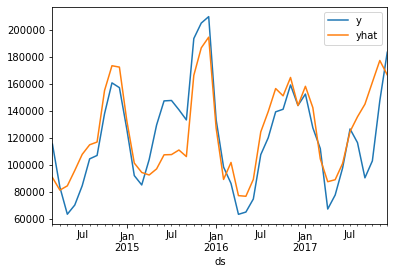

In [47]:
pd.concat([ABC_df_Pesticides_FBP.set_index('ds')['y'],forecast.set_index('ds')['yhat']],axis=1).plot()

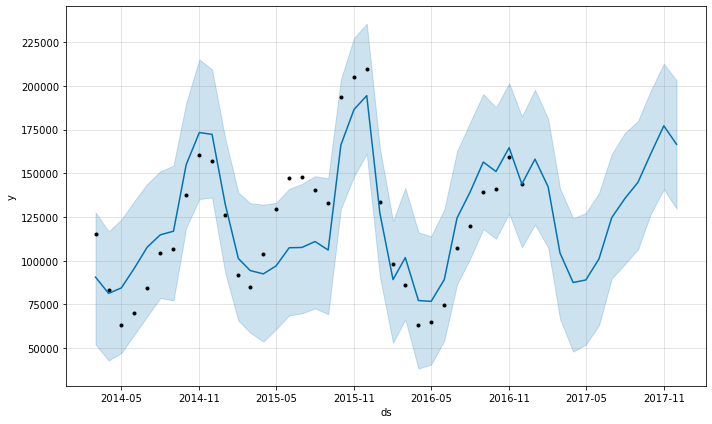

In [48]:
fig1 = m.plot(forecast)

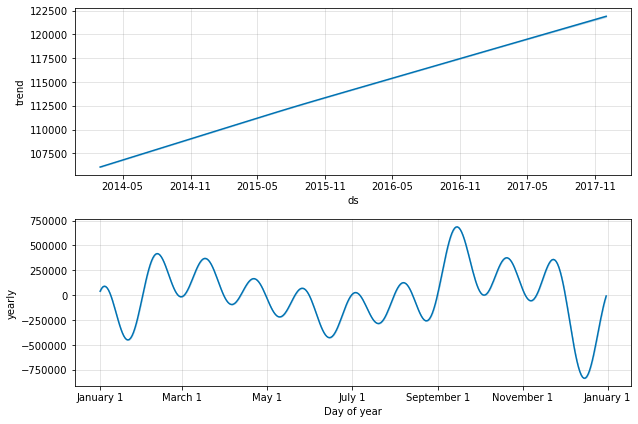

In [49]:
fig2 = m.plot_components(forecast)

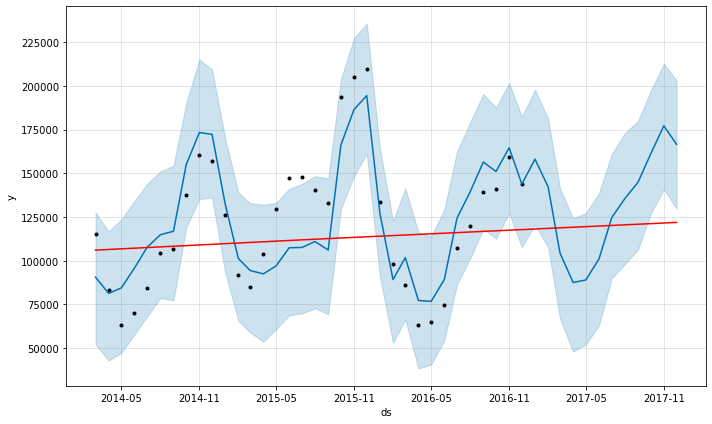

In [50]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [51]:
fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)

In [52]:
#check for cross_validation
cv_results = cross_validation( model = m, initial = '731 days', horizon = '120 days')
cv_results

INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-04-05 00:00:00 and 2016-08-03 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


ds           yhat     yhat_lower     yhat_upper           y  \
0  2016-05-01  143755.736377  114434.558136  174527.895070   65060.370   
1  2016-06-01  129098.425861   94718.635654  160402.211680   74734.830   
2  2016-07-01  159517.808450  126670.921281  189111.846158  107557.200   
3  2016-08-01  211050.610463  180280.064626  240581.186528  119999.430   
4  2016-07-01  197304.401540  164890.056859  228567.702090  107557.200   
5  2016-08-01  225604.494650  192188.913831  259624.863719  119999.430   
6  2016-09-01  209234.892211  177245.436180  240233.768499  139234.230   
7  2016-10-01  143545.632634  109626.363996  179130.447038  141130.395   
8  2016-09-01  260288.538514  224081.060839  297472.047160  139234.230   
9  2016-10-01  166046.058554  131673.190207  203315.442805  141130.395   
10 2016-11-01  152249.640867  113849.717292  189873.516915  159113.295   
11 2016-12-01  103541.577892   65650.043285  136876.834471  143949.825   

       cutoff  
0  2016-04-05  
1  2016-04-05  
2  2016-04-05  
3  2016-04-05  
4  2016-06-04  
5  2016-06-04  
6  2016-06-04  
7  2016-06-04  
8  2016-08-03  
9  2016-08-03  
10 2016-08-03  
11 2016-08-03

In [53]:
#Check performance metrics
df_p = performance_metrics(cv_results)
df_p

horizon           mse           rmse            mae      mape     mdape  \
0   26 days  6.192961e+09   78695.366377   78695.366377  1.209575  1.209575   
1   27 days  8.054560e+09   89747.201540   89747.201540  0.834414  0.834414   
2   29 days  1.465415e+10  121054.308514  121054.308514  0.869429  0.869429   
3   57 days  2.955401e+09   54363.595861   54363.595861  0.727420  0.727420   
4   58 days  1.115243e+10  105605.064650  105605.064650  0.880046  0.880046   
5   59 days  6.207903e+08   24915.663554   24915.663554  0.176544  0.176544   
6   87 days  2.699905e+09   51960.608450   51960.608450  0.483097  0.483097   
7   89 days  4.900093e+09   70000.662211   70000.662211  0.502755  0.502755   
8   90 days  4.710975e+07    6863.654133    6863.654133  0.043137  0.043137   
9  118 days  8.290317e+09   91051.180463   91051.180463  0.758763  0.758763   
10 119 days  5.833373e+06    2415.237634    2415.237634  0.017114  0.017114   
11 120 days  1.632826e+09   40408.247108   40408.247108  0.280711  0.280711   

    coverage  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0  
5        1.0  
6        0.0  
7        0.0  
8        1.0  
9        0.0  
10       1.0  
11       0.0

In [54]:
forecast_FBP = forecast.loc[forecast['ds'] > pd.to_datetime(train_end_date)]
forecast_FBP.rename(columns={ 'ds' : 'MONTH'},inplace = True)
forecast_FBP['MONTH'] = pd.to_datetime(forecast_FBP['MONTH'])
forecast_FBP.set_index('MONTH', inplace=True)
forecast_FBP.drop(columns =['trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper'], axis = 1, inplace = True)

In [55]:
forecast_FBP

yhat
MONTH                    
2017-01-01  158121.293882
2017-02-01  142308.350041
2017-03-01  104421.939257
2017-04-01   87530.771569
2017-05-01   88996.204817
2017-06-01  101048.789918
2017-07-01  124630.112792
2017-08-01  135566.241087
2017-09-01  144886.319374
2017-10-01  161122.738240
2017-11-01  177230.025541
2017-12-01  166592.198328

In [56]:
ABC_df_Pesticides_FBP_residue = ABC_df_Pesticides_FBP.loc[forecast['ds'] > pd.to_datetime(train_end_date)]

ABC_df_Pesticides_FBP_residue.rename(columns={ 'ds' : 'MONTH', 'y' : 'VALUE'},inplace = True)
ABC_df_Pesticides_FBP_residue.set_index('MONTH', inplace=True)

In [57]:
residual_FBP = ABC_df_Pesticides_FBP_residue['VALUE'] - forecast_FBP['yhat']
residual_FBP

MONTH
2017-01-01    -5739.683882
2017-02-01   -14925.305041
2017-03-01     7645.010743
2017-04-01   -20221.541569
2017-05-01   -11325.424817
2017-06-01    -3364.904918
2017-07-01     1929.057208
2017-08-01   -19129.686087
2017-09-01   -54493.964374
2017-10-01   -58188.478240
2017-11-01   -29844.405541
2017-12-01    16742.931672
dtype: float64

In [58]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residual_FBP**2)))

Root Mean Squared Error: 27016.7001967822


In [59]:
print(mean_absolute_error(test.loc[pd.to_datetime(test_start_date)] ,forecast_FBP.loc[pd.to_datetime(test_start_date)]))

5739.683882023499


In [60]:
#Calculate MAPE%
y_true = test.loc[pd.to_datetime(test_start_date):].values
y_pred = forecast_FBP.loc[pd.to_datetime(test_start_date):].values

p_mean_absolute_percentage_error(y_true, y_pred)

19.54375075347391

# Auto Arima

In [61]:
ABC_df_Pesticides_AA = ABC_df_Pesticides.copy(deep=True)

In [62]:
model = pm.auto_arima(ABC_df_Pesticides_AA['VALUE'], m = predict_periods,seasonal= True,start_P= 0,start_q= 0,max_order= 4,test = 'adf',
                     error_action= 'ignore',suppress_warnings= True,stepwise= True,trace= True)

Performing stepwise search to minimize aic
 ARIMA(2,2,0)(0,0,1)[12]             : AIC=1031.964, Time=0.33 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1028.489, Time=0.07 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1030.397, Time=0.20 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1029.521, Time=0.28 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1030.903, Time=0.14 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1031.926, Time=0.15 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=inf, Time=1.02 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1028.569, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1027.773, Time=0.16 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1029.483, Time=0.33 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1030.709, Time=0.84 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1030.714, Time=0.22 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=1022.627, Time=0.30 sec
 ARIMA(0,2,2)(1,0,0)[12]             : AIC=1024.224, Time=0.52 sec
 ARIMA(0,2,2)(0,0,1)[12]

In [63]:
#Model suumary 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   46
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -508.314
Date:                Wed, 23 Jun 2021   AIC                           1022.627
Time:                        13:18:44   BIC                           1027.980
Sample:                             0   HQIC                          1024.612
                                 - 46                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6366      0.278     -2.288      0.022      -1.182      -0.091
ma.L2         -0.3214      0.301     -1.069      0.285      -0.911       0.268
sigma2      8.427e+08   1.91e-10    4.4e+18      0.000    8.43e+08    8.43e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                10.28
Prob(Q):                              0.78   Prob(JB):                         0.01
Heteroskedasticity (H):               2.20   Skew:                            -0.63
Prob(H) (two-sided):                  0.14   Kurtosis:                         5.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.66e+34. Standard errors may be unstable.
"""

In [64]:
ABC_df_Pesticides_AA

VALUE
MONTH                 
2014-03-01  115282.935
2014-04-01   83449.215
2014-05-01   63467.775
2014-06-01   70248.195
2014-07-01   84546.000
2014-08-01  104433.930
2014-09-01  106950.105
2014-10-01  137808.090
2014-11-01  160662.870
2014-12-01  157137.615
2015-01-01  126236.565
2015-02-01   92046.195
2015-03-01   85128.120
2015-04-01  103921.020
2015-05-01  129530.565
2015-06-01  147318.255
2015-07-01  147642.615
2015-08-01  140753.745
2015-09-01  133256.520
2015-10-01  193465.800
2015-11-01  204905.250
2015-12-01  209671.245
2016-01-01  133442.100
2016-02-01   98353.440
2016-03-01   86225.805
2016-04-01   63391.545
2016-05-01   65060.370
2016-06-01   74734.830
2016-07-01  107557.200
2016-08-01  119999.430
2016-09-01  139234.230
2016-10-01  141130.395
2016-11-01  159113.295
2016-12-01  143949.825
2017-01-01  152381.610
2017-02-01  127383.045
2017-03-01  112066.950
2017-04-01   67309.230
2017-05-01   77670.780
2017-06-01   97683.885
2017-07-01  126559.170
2017-08-01  116436.555
2017-09-01   90392.355
2017-10-01  102934.260
2017-11-01  147385.620
2017-12-01  183335.130

In [65]:
#Splitting the data into training and testing set
train = ABC_df_Pesticides_AA[(ABC_df_Pesticides_AA.index.get_level_values(0)>= pd.to_datetime(train_start_date) ) &
                               (ABC_df_Pesticides_AA.index.get_level_values(0)<= pd.to_datetime(train_end_date))]
test = ABC_df_Pesticides_AA[(ABC_df_Pesticides_AA.index.get_level_values(0)> pd.to_datetime(train_end_date))]

In [66]:
train

VALUE
MONTH                 
2014-03-01  115282.935
2014-04-01   83449.215
2014-05-01   63467.775
2014-06-01   70248.195
2014-07-01   84546.000
2014-08-01  104433.930
2014-09-01  106950.105
2014-10-01  137808.090
2014-11-01  160662.870
2014-12-01  157137.615
2015-01-01  126236.565
2015-02-01   92046.195
2015-03-01   85128.120
2015-04-01  103921.020
2015-05-01  129530.565
2015-06-01  147318.255
2015-07-01  147642.615
2015-08-01  140753.745
2015-09-01  133256.520
2015-10-01  193465.800
2015-11-01  204905.250
2015-12-01  209671.245
2016-01-01  133442.100
2016-02-01   98353.440
2016-03-01   86225.805
2016-04-01   63391.545
2016-05-01   65060.370
2016-06-01   74734.830
2016-07-01  107557.200
2016-08-01  119999.430
2016-09-01  139234.230
2016-10-01  141130.395
2016-11-01  159113.295
2016-12-01  143949.825

In [67]:
test

VALUE
MONTH                 
2017-01-01  152381.610
2017-02-01  127383.045
2017-03-01  112066.950
2017-04-01   67309.230
2017-05-01   77670.780
2017-06-01   97683.885
2017-07-01  126559.170
2017-08-01  116436.555
2017-09-01   90392.355
2017-10-01  102934.260
2017-11-01  147385.620
2017-12-01  183335.130

In [68]:
#Fitting the model in the train set
model.fit(train['VALUE'])

ARIMA(order=(0, 2, 2), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [69]:
#Forecasting the train model and comparing the value
forecast = model.predict(n_periods=predict_periods,return_conf_int=True)

In [70]:
#Printing the forecast values in the test set
forecast

(array([138315.97496886, 140761.12103446, 143206.26710006, 145651.41316567,
        148096.55923127, 150541.70529687, 152986.85136248, 155431.99742808,
        157877.14349369, 160322.28955929, 162767.43562489, 165212.5816905 ]),
 array([[  80693.84706998,  195938.10286773],
        [  41854.76633825,  239667.47573067],
        [  13116.14315808,  273296.39104205],
        [ -11747.78951208,  303050.61584341],
        [ -34569.67274521,  330762.79120775],
        [ -56175.6127635 ,  357259.02335725],
        [ -77015.49685273,  382989.19957768],
        [ -97363.02514145,  408227.01999761],
        [-117397.37162984,  433151.65861721],
        [-137242.09883814,  457886.67795672],
        [-156985.78557798,  482520.65682776],
        [-176693.85243216,  507119.01581315]]))

In [71]:
#Resttin the forecast df to and creating the column name for prediction
forecast_df=pd.DataFrame(forecast[0],index= test.index,columns=['Prediction'])

In [72]:
#Printing the dataframe for forecast_dfABC_df
forecast_df

Prediction
MONTH                    
2017-01-01  138315.974969
2017-02-01  140761.121034
2017-03-01  143206.267100
2017-04-01  145651.413166
2017-05-01  148096.559231
2017-06-01  150541.705297
2017-07-01  152986.851362
2017-08-01  155431.997428
2017-09-01  157877.143494
2017-10-01  160322.289559
2017-11-01  162767.435625
2017-12-01  165212.581690

<AxesSubplot:xlabel='MONTH'>

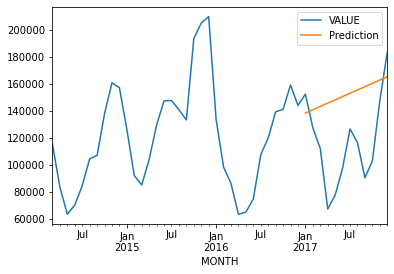

In [73]:
#Conactenating the observed and forecast model and plotting the graph
pd.concat([ABC_df_Pesticides_AA['VALUE'],forecast_df],axis=1).plot()

In [74]:
forecast1 = model.predict(n_periods=predict_periods,return_conf_int=True)
forecast1

(array([138315.97496886, 140761.12103446, 143206.26710006, 145651.41316567,
        148096.55923127, 150541.70529687, 152986.85136248, 155431.99742808,
        157877.14349369, 160322.28955929, 162767.43562489, 165212.5816905 ]),
 array([[  80693.84706998,  195938.10286773],
        [  41854.76633825,  239667.47573067],
        [  13116.14315808,  273296.39104205],
        [ -11747.78951208,  303050.61584341],
        [ -34569.67274521,  330762.79120775],
        [ -56175.6127635 ,  357259.02335725],
        [ -77015.49685273,  382989.19957768],
        [ -97363.02514145,  408227.01999761],
        [-117397.37162984,  433151.65861721],
        [-137242.09883814,  457886.67795672],
        [-156985.78557798,  482520.65682776],
        [-176693.85243216,  507119.01581315]]))

In [75]:
forecast_range=pd.date_range(start= pd.to_datetime(test_start_date) ,periods= predict_periods,freq='MS')
forecast_range

DatetimeIndex(['2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [76]:
forecast1_df = pd.DataFrame(forecast1[0],index= forecast_range,columns=['Prediction'])

In [77]:
forecast1_df

Prediction
2017-01-01  138315.974969
2017-02-01  140761.121034
2017-03-01  143206.267100
2017-04-01  145651.413166
2017-05-01  148096.559231
2017-06-01  150541.705297
2017-07-01  152986.851362
2017-08-01  155431.997428
2017-09-01  157877.143494
2017-10-01  160322.289559
2017-11-01  162767.435625
2017-12-01  165212.581690

<AxesSubplot:>

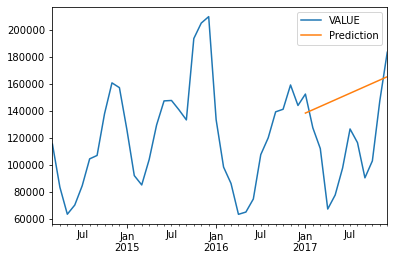

In [78]:
pd.concat([ABC_df_Pesticides_AA['VALUE'],forecast1_df],axis=1).plot()

In [79]:
lower = pd.Series(forecast1[1][:,0],index=forecast_range)
upper = pd.Series(forecast1[1][:,1],index=forecast_range)

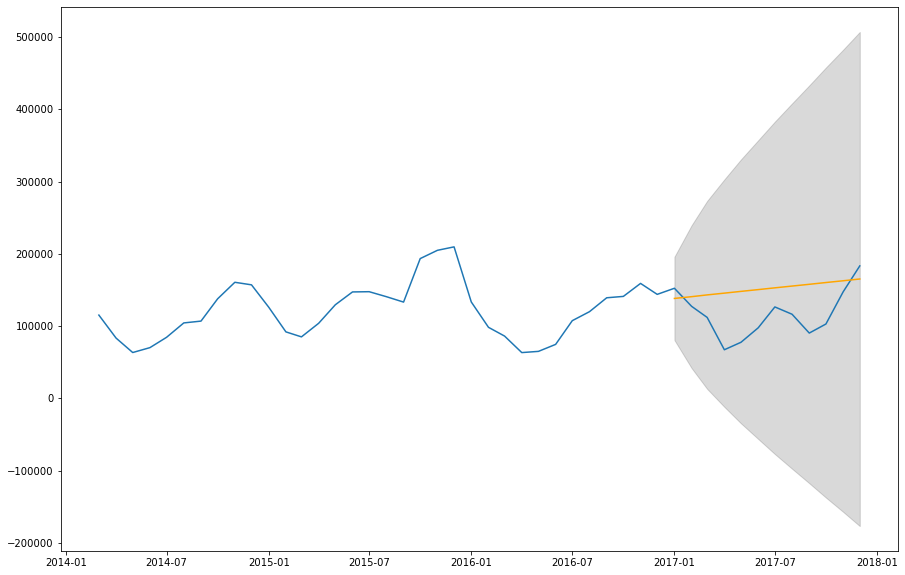

In [80]:
plt.figure(figsize=(15,10))
plt.plot(ABC_df_Pesticides_AA['VALUE'])
plt.plot(forecast1_df,color = 'orange')
plt.fill_between(forecast_range,lower,upper,color = 'k',alpha = .15)


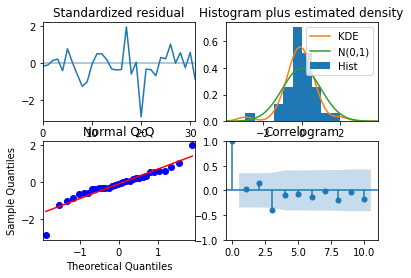

In [81]:
out = model.plot_diagnostics()

In [82]:
residuals_AA = test['VALUE'] - forecast_df['Prediction']
residuals_AA

MONTH
2017-01-01    14065.635031
2017-02-01   -13378.076034
2017-03-01   -31139.317100
2017-04-01   -78342.183166
2017-05-01   -70425.779231
2017-06-01   -52857.820297
2017-07-01   -26427.681362
2017-08-01   -38995.442428
2017-09-01   -67484.788494
2017-10-01   -57388.029559
2017-11-01   -15381.815625
2017-12-01    18122.548310
dtype: float64

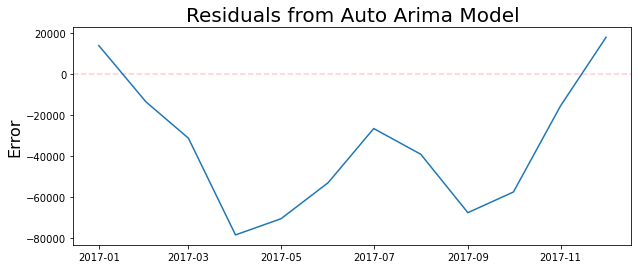

In [83]:
plt.figure(figsize=(10,4))
plt.plot(residuals_AA)
plt.title('Residuals from Auto Arima Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

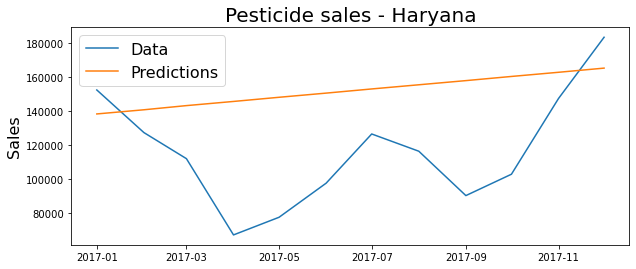

In [84]:
plt.figure(figsize=(10,4))

plt.plot(test)
plt.plot(forecast_df)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Pesticide sales - Haryana', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [85]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_AA**2)))

Root Mean Squared Error: 46430.401124465534


In [86]:
print(mean_absolute_error(test['VALUE'] ,forecast_df['Prediction']))

40334.09305311768


In [87]:
#Calculate MAPE%
y_true = test.loc[pd.to_datetime(test_start_date):].values
y_pred = forecast_df.loc[pd.to_datetime(test_start_date):].values

p_mean_absolute_percentage_error(y_true, y_pred)

42.816445936563106

# ARMA model

In [88]:
ABC_df_Pesticides_ARMA = ABC_df_Pesticides.copy(deep=True)

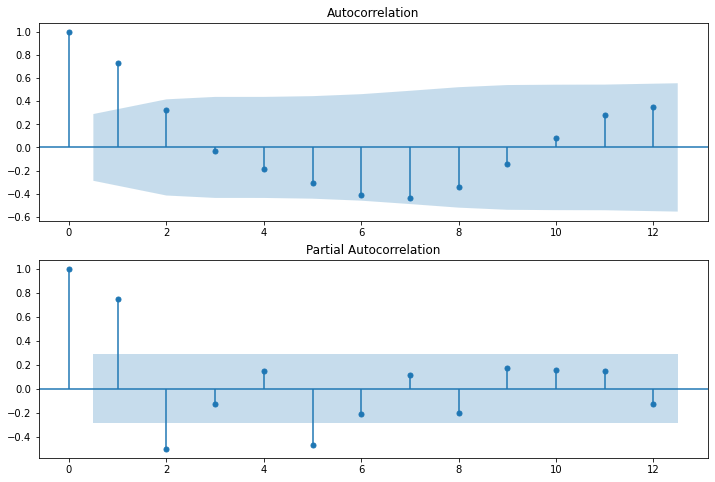

In [89]:
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ABC_df_Pesticides_ARMA,lags=predict_periods,ax = ax1)
ax2=fig.add_subplot(212)
fig= sm.graphics.tsa.plot_pacf(ABC_df_Pesticides_ARMA,lags=predict_periods,ax = ax2)

In [90]:
train = ABC_df_Pesticides_ARMA[(ABC_df_Pesticides_ARMA.index.get_level_values(0) >= pd.to_datetime(train_start_date)) &
                               (ABC_df_Pesticides_ARMA.index.get_level_values(0) <= pd.to_datetime(train_end_date))]
test = ABC_df_Pesticides_ARMA[(ABC_df_Pesticides_ARMA.index.get_level_values(0) > pd.to_datetime(train_end_date))]

In [91]:
train

VALUE
MONTH                 
2014-03-01  115282.935
2014-04-01   83449.215
2014-05-01   63467.775
2014-06-01   70248.195
2014-07-01   84546.000
2014-08-01  104433.930
2014-09-01  106950.105
2014-10-01  137808.090
2014-11-01  160662.870
2014-12-01  157137.615
2015-01-01  126236.565
2015-02-01   92046.195
2015-03-01   85128.120
2015-04-01  103921.020
2015-05-01  129530.565
2015-06-01  147318.255
2015-07-01  147642.615
2015-08-01  140753.745
2015-09-01  133256.520
2015-10-01  193465.800
2015-11-01  204905.250
2015-12-01  209671.245
2016-01-01  133442.100
2016-02-01   98353.440
2016-03-01   86225.805
2016-04-01   63391.545
2016-05-01   65060.370
2016-06-01   74734.830
2016-07-01  107557.200
2016-08-01  119999.430
2016-09-01  139234.230
2016-10-01  141130.395
2016-11-01  159113.295
2016-12-01  143949.825

In [92]:
# define model
model = ARMA(train, order=(1,1))

In [93]:
model_fit = model.fit()

In [94]:
#summary of the model
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  VALUE   No. Observations:                   34
Model:                     ARMA(1, 1)   Log Likelihood                -387.763
Method:                       css-mle   S.D. of innovations          21329.208
Date:                Wed, 23 Jun 2021   AIC                            783.527
Time:                        13:18:59   BIC                            789.632
Sample:                    03-01-2014   HQIC                           785.609
                         - 12-01-2016                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.215e+05   1.45e+04      8.381      0.000    9.31e+04     1.5e+05
ar.L1.VALUE     0.6711      0.132      5.078      0.000       0.412       0.930
ma.L1.VALUE     0.3888      0.135      2.876    

In [95]:
test

VALUE
MONTH                 
2017-01-01  152381.610
2017-02-01  127383.045
2017-03-01  112066.950
2017-04-01   67309.230
2017-05-01   77670.780
2017-06-01   97683.885
2017-07-01  126559.170
2017-08-01  116436.555
2017-09-01   90392.355
2017-10-01  102934.260
2017-11-01  147385.620
2017-12-01  183335.130

In [96]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2017-01-01 to 2017-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VALUE   12 non-null     float64
dtypes: float64(1)
memory usage: 192.0 bytes


In [97]:
#get the predictions and residuals
predictions = model_fit.predict(start=pd.to_datetime(test_start_date), end = pd.to_datetime(test_end_date))

In [98]:
predictions

2017-01-01    131805.339489
2017-02-01    128406.490717
2017-03-01    126125.616064
2017-04-01    124594.983331
2017-05-01    123567.817476
2017-06-01    122878.514504
2017-07-01    122415.942090
2017-08-01    122105.522368
2017-09-01    121897.208164
2017-10-01    121757.414186
2017-11-01    121663.602263
2017-12-01    121600.647642
Freq: MS, dtype: float64

In [99]:
Pred_range=pd.date_range(start = pd.to_datetime(test_end_date),periods= predict_periods,freq='MS')
Pred_range

DatetimeIndex(['2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01',
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01'],
              dtype='datetime64[ns]', freq='MS')

In [100]:
Pred_df = predictions.to_frame()
Pred_df.info()
Pred_df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2017-01-01 to 2017-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       12 non-null     float64
dtypes: float64(1)
memory usage: 192.0 bytes


0
2017-01-01  131805.339489
2017-02-01  128406.490717
2017-03-01  126125.616064
2017-04-01  124594.983331
2017-05-01  123567.817476
2017-06-01  122878.514504
2017-07-01  122415.942090
2017-08-01  122105.522368
2017-09-01  121897.208164
2017-10-01  121757.414186
2017-11-01  121663.602263
2017-12-01  121600.647642

In [101]:
Pred_df.columns = ['PRED_VALUE']

In [102]:
residuals_ARMA = test['VALUE'] - Pred_df['PRED_VALUE']
residuals_ARMA

MONTH
2017-01-01    20576.270511
2017-02-01    -1023.445717
2017-03-01   -14058.666064
2017-04-01   -57285.753331
2017-05-01   -45897.037476
2017-06-01   -25194.629504
2017-07-01     4143.227910
2017-08-01    -5668.967368
2017-09-01   -31504.853164
2017-10-01   -18823.154186
2017-11-01    25722.017737
2017-12-01    61734.482358
dtype: float64

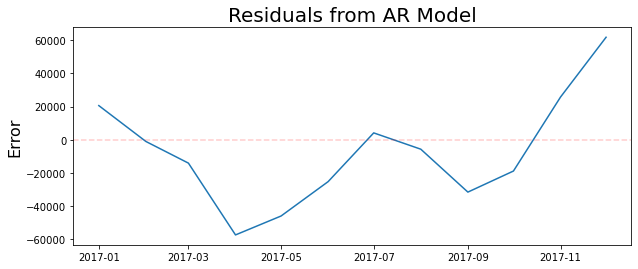

In [103]:
plt.figure(figsize=(10,4))
plt.plot(residuals_ARMA)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

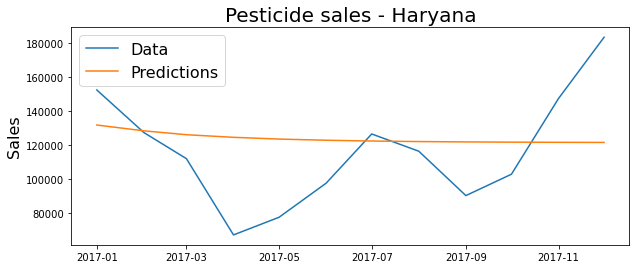

In [104]:
plt.figure(figsize=(10,4))

plt.plot(test)
plt.plot(Pred_df)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Pesticide sales - Haryana', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [105]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_ARMA**2)))

Root Mean Squared Error: 32292.90469519416


In [106]:
print(mean_absolute_error(test['VALUE'] ,Pred_df['PRED_VALUE']))

25969.37544379565


In [107]:
#Calculate MAPE%
y_true = test.loc[pd.to_datetime(test_start_date):].values
y_pred = Pred_df.loc[pd.to_datetime(test_start_date):].values

p_mean_absolute_percentage_error(y_true, y_pred)

25.77093622547983

# SARIMAX Model

In [108]:
ABC_df_Pesticides_SARIMAX = ABC_df_Pesticides.copy(deep=True)

In [109]:
p = range(0, 3)
d = range(0, 1)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[0], x[0], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ABC_df_Pesticides_SARIMAX,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
               
            continue            

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 0, 12)
SARIMAX: (0, 0, 1) x (0, 0, 0, 12)
SARIMAX: (0, 0, 2) x (1, 1, 1, 12)
SARIMAX: (0, 0, 2) x (1, 1, 1, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1186.6696208109452
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1186.6696208109452
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1186.6696208109452
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:497.3962086220613
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:497.3962086220613
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:497.3962086220613
ARIMA(0, 0, 0)x(2, 2, 2, 12)12 - AIC:10.0
ARIMA(0, 0, 0)x(2, 2, 2, 12)12 - AIC:10.0
ARIMA(0, 0, 0)x(2, 2, 2, 12)12 - AIC:10.0
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:4764.9624354561765
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:4764.9624354561765
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:4764.9624354561765
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:469.6630920775274
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:469.6630920775274
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:469.6630920775274
ARIMA(0, 0,

In [110]:
# Fitting the data to SARIMA model 
model = sm.tsa.statespace.SARIMAX(ABC_df_Pesticides_SARIMAX['VALUE'], 
                                order=(0, 0, 0),
                                seasonal_order=(2, 2, 2, 12),  
                                continueenforce_invertibility=False)

In [111]:
results = model.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0585   4870.290    1.2e-05      1.000   -9545.534    9545.651
ar.S.L24      -0.6760   1.41e+04  -4.78e-05      1.000   -2.77e+04    2.77e+04
ma.S.L12      -0.6058     50.823     -0.012      0.990    -100.217      99.006
ma.S.L24       0.2426   2.91e+04   8.34e-06      1.000    -5.7e+04     5.7e+04
sigma2      5.165e+09      0.312   1.65e+10      0.000    5.16e+09    5.16e+09


In [112]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:                         VALUE   No. Observations:                   46
Model:             SARIMAX(2, 2, [1, 2], 12)   Log Likelihood                -272.053
Date:                       Wed, 23 Jun 2021   AIC                            554.106
Time:                               13:20:39   BIC                            559.561
Sample:                           03-01-2014   HQIC                           555.391
                                - 12-01-2017                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0585   4870.290    1.2e-05      1.000   -9545.534    9545.651
ar.S.L24      -0.6760   1.41e+04  -4.78e-05      1.000   -2.77e+04    2.77e+04
ma.S.L12      -0.6058     50.823     -0.012      0.990    -100.217      99.006
ma.S.L24       0.2426   2.91e+04   8.34e-06      1.000    -5.7e+04     5.7e+04
sigma2      5.165e+09      0.312   1.65e+10      0.000    5.16e+09    5.16e+09
===================================================================================
Ljung-Box (L1) (Q):                   4.01   Jarque-Bera (JB):                 1.08
Prob(Q):                              0.05   Prob(JB):                         0.58
Heteroskedasticity (H):               0.68   Skew:                            -0.02
Prob(H) (two-sided):                  0.63   Kurtosis:                         1.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.51e+25. Standard errors may be unstable.
"""

In [113]:
# Checking diagnostic plots
results.plot_diagnostics(figsize=(20, 20))
plt.show()

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1440x1440 with 0 Axes>

In [114]:
train = ABC_df_Pesticides_SARIMAX[(ABC_df_Pesticides_SARIMAX.index.get_level_values(0) >= pd.to_datetime(train_start_date)) &
                               (ABC_df_Pesticides_SARIMAX.index.get_level_values(0) <= pd.to_datetime(train_end_date))]
test = ABC_df_Pesticides_SARIMAX[(ABC_df_Pesticides_SARIMAX.index.get_level_values(0) > pd.to_datetime(train_end_date))]

In [115]:
forecast = results.predict(n_periods=predict_periods,return_conf_int=True)
forecast

2014-03-01    0.000000e+00
2014-04-01    1.061802e-10
2014-05-01   -1.377263e-10
2014-06-01   -2.541114e-10
2014-07-01    8.371177e-11
2014-08-01    2.421875e-10
2014-09-01    2.200158e-10
2014-10-01    7.166040e-11
2014-11-01   -1.674967e-11
2014-12-01   -1.070441e-11
2015-01-01   -3.138952e-12
2015-02-01    1.970827e-10
2015-03-01    2.082507e+05
2015-04-01    1.507452e+05
2015-05-01    1.146502e+05
2015-06-01    1.268985e+05
2015-07-01    1.527265e+05
2015-08-01    1.886527e+05
2015-09-01    1.931980e+05
2015-10-01    2.489408e+05
2015-11-01    2.902264e+05
2015-12-01    2.838583e+05
2016-01-01    2.280376e+05
2016-02-01    1.662751e+05
2016-03-01    2.889874e+04
2016-04-01    9.223844e+04
2016-05-01    1.552860e+05
2016-06-01    1.785349e+05
2016-07-01    1.648647e+05
2016-08-01    1.334742e+05
2016-09-01    1.183315e+05
2016-10-01    1.891638e+05
2016-11-01    1.857256e+05
2016-12-01    1.972667e+05
2017-01-01    9.946687e+04
2017-02-01    7.430279e+04
2017-03-01    1.379974e+05
2

In [116]:
Predicted_df = pd.DataFrame(forecast.loc[forecast.index.isin(test.index)], columns=["PRED_VALUE"])
Predicted_df

Empty DataFrame
Columns: [PRED_VALUE]
Index: []

<AxesSubplot:>

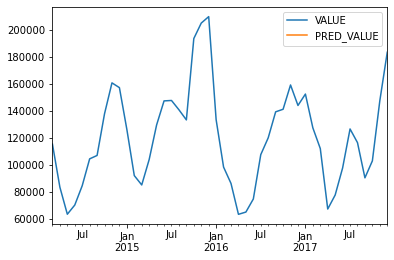

In [117]:
pd.concat([ABC_df_Pesticides_SARIMAX['VALUE'], Predicted_df], axis=1).plot()

In [118]:
residuals_SARIMAX = test['VALUE'] - Pred_df['PRED_VALUE']
residuals_SARIMAX

MONTH
2017-01-01    20576.270511
2017-02-01    -1023.445717
2017-03-01   -14058.666064
2017-04-01   -57285.753331
2017-05-01   -45897.037476
2017-06-01   -25194.629504
2017-07-01     4143.227910
2017-08-01    -5668.967368
2017-09-01   -31504.853164
2017-10-01   -18823.154186
2017-11-01    25722.017737
2017-12-01    61734.482358
dtype: float64

In [119]:
#get the predictions

predict_future = results.forecast(len(test))
predict_future

2018-01-01    209297.868963
2018-02-01    175918.173288
2018-03-01    146174.846907
2018-04-01    112084.452886
2018-05-01    144391.917275
2018-06-01    177486.604593
2018-07-01    195681.187433
2018-08-01    166017.798446
2018-09-01    109982.137509
2018-10-01    162151.858981
2018-11-01    219340.324934
2018-12-01    285333.368886
Freq: MS, Name: predicted_mean, dtype: float64

In [120]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_SARIMAX**2)))

Root Mean Squared Error: 32292.90469519416


In [121]:
print(mean_absolute_error(test['VALUE'] ,Pred_df['PRED_VALUE']))

25969.37544379565


In [122]:
#Calculate MAPE%
y_true = test.loc[pd.to_datetime(test_start_date):].values
y_pred = Pred_df.loc[pd.to_datetime(test_start_date):].values

p_mean_absolute_percentage_error(y_true, y_pred)

25.77093622547983

# Holt-Winters - ETS(A, A, A) - Holt Winter's linear method with additive errors

In [123]:
ABC_df_Pesticides_hwm =  ABC_df_Pesticides.copy(deep=True)

In [124]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [125]:
#Splitting the data into training and testing set
train = ABC_df_Pesticides_hwm[(ABC_df_Pesticides_hwm.index.get_level_values(0)>= pd.to_datetime(train_start_date) ) &
                               (ABC_df_Pesticides_hwm.index.get_level_values(0)<= pd.to_datetime(train_end_date))]
test = ABC_df_Pesticides_hwm[(ABC_df_Pesticides_hwm.index.get_level_values(0)> pd.to_datetime(train_end_date))]

In [126]:
pred1 = ExponentialSmoothing(np.asarray(train['VALUE']), trend='additive', damped=False, seasonal='additive',
                                  seasonal_periods = 12).fit() #[:'2017-01-01']
print('')
print('== Holt-Winters Additive ETS(A,A,A) Parameters ==')
print('')
alpha_value = np.round(pred1.params['smoothing_level'], 4)
print('Smoothing Level: ', alpha_value)
print('Smoothing Slope: ', np.round(pred1.params['smoothing_trend'], 4))
print('Smoothing Seasonal: ', np.round(pred1.params['smoothing_seasonal'], 4))
print('Initial Level: ', np.round(pred1.params['initial_level'], 4))
print('Initial Slope: ', np.round(pred1.params['initial_trend'], 4))
print('Initial Seasons: ', np.round(pred1.params['initial_seasons'], 4))
print('')

### Forecast for next 12 months

y_pred1 =  pred1.forecast(steps = 12)
df_pred1 = pd.DataFrame({'Y_hat':y_pred1,'Y':test['VALUE']})
print(df_pred1)


== Holt-Winters Additive ETS(A,A,A) Parameters ==

Smoothing Level:  0.995
Smoothing Slope:  0.0001
Smoothing Seasonal:  0.005
Initial Level:  95545.62
Initial Slope:  2952.2166
Initial Seasons:  [ 19737.315 -12096.405 -32077.845 -25297.425 -10999.62    8888.31
  11404.485  42262.47   65117.25   61591.995  30690.945  -3499.425]

                    Y_hat           Y
MONTH                                
2017-01-01  115795.627946  152381.610
2017-02-01   84766.972849  127383.045
2017-03-01  110608.734517  112066.950
2017-04-01   82337.061092   67309.230
2017-05-01   65339.787033   77670.780
2017-06-01   74795.322373   97683.885
2017-07-01   91985.686897  126559.170
2017-08-01  114620.082035  116436.555
2017-09-01  120280.082720   90392.355
2017-10-01  154047.814674  102934.260
2017-11-01  179761.938890  147385.620
2017-12-01  179313.951121  183335.130


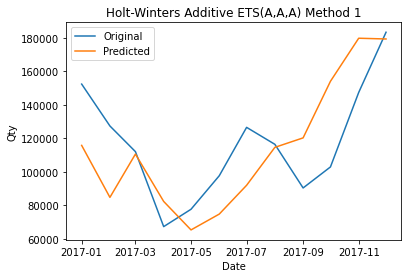

In [127]:
### Plot

fig2, ax = plt.subplots()
ax.plot(df_pred1.Y, label='Original')
ax.plot(df_pred1.Y_hat, label='Predicted')

plt.legend(loc='upper left')
plt.title('Holt-Winters Additive ETS(A,A,A) Method 1')
plt.ylabel('Qty')
plt.xlabel('Date')
plt.show()

In [130]:
residuals_hwm = df_pred1.Y - df_pred1.Y_hat
residuals_hwm


MONTH
2017-01-01    36585.982054
2017-02-01    42616.072151
2017-03-01     1458.215483
2017-04-01   -15027.831092
2017-05-01    12330.992967
2017-06-01    22888.562627
2017-07-01    34573.483103
2017-08-01     1816.472965
2017-09-01   -29887.727720
2017-10-01   -51113.554674
2017-11-01   -32376.318890
2017-12-01     4021.178879
dtype: float64

In [131]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_hwm**2)))

Root Mean Squared Error: 28617.387527736646


In [132]:
print(mean_absolute_error(df_pred1.Y, df_pred1.Y_hat))

23724.69938384723


In [133]:

mape    =  p_mean_absolute_percentage_error(df_pred1.Y, df_pred1.Y_hat)

print("For alpha = %1.2f, MAPE is %3.2f" %(alpha_value, mape))

For alpha = 0.99, MAPE is 21.35


In [134]:
#Future forecast
final_model = ExponentialSmoothing(ABC_df_Pesticides_hwm['VALUE'], trend='additive', damped=False, seasonal='additive',
                                  seasonal_periods = 12).fit()

In [135]:
pred=final_model.forecast(12)
pred

2018-01-01    155191.942556
2018-02-01    123944.262613
2018-03-01    150110.742749
2018-04-01    121233.303904
2018-05-01    104198.292182
2018-06-01    113912.956338
2018-07-01    131151.188311
2018-08-01    153972.041356
2018-09-01    159433.675405
2018-10-01    193233.338114
2018-11-01    219031.708283
2018-12-01    218447.146362
Freq: MS, dtype: float64

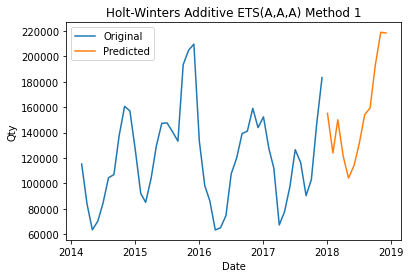

In [136]:
### Plot

fig2, ax = plt.subplots()
ax.plot(ABC_df_Pesticides_hwm['VALUE'], label='Original')
ax.plot(pred, label='Predicted')

plt.legend(loc='upper left')
plt.title('Holt-Winters Additive ETS(A,A,A) Method 1')
plt.ylabel('Qty')
plt.xlabel('Date')
plt.show()

# To check if Rainfall has any effect on Insecticides sales

In [137]:
Rainfall = [12.9,16.7,26.5,7.5, 20,25.8,71,33.5,67,10.8,0.2,9.4,12.1,6.6,70.7,34.9,8.3,43.5,127.9,84.4,32,3.8,2.3,0.2,
            0,1.1,20.7,0.6,26.8,34.8,155.1,133.8,13.7,5.2,0,0.9,33.8,0.3,7.2,3.7,10.1,121.8,67.7,74.7,91.8,0,1.8,4.2]

In [138]:
ABC_df_Pesticides['Rainfall'] = Rainfall[rolling_period - 1:]

Text(0, 0.5, 'Sales')

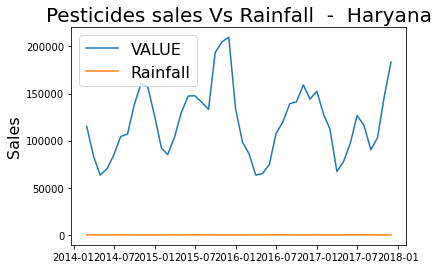

In [139]:
plt.plot(ABC_df_Pesticides)

plt.legend(('VALUE', 'Rainfall'), fontsize=16)

plt.title('Pesticides sales Vs Rainfall  -  Haryana', fontsize=20)
plt.ylabel('Sales', fontsize=16)

#Feature scaling for 'VALUE' column as Rainfall column

In [140]:
#Taking Rainfall and Value column on a common scale
ABC_df_Pesticides['VALUE'] = ABC_df_Pesticides['VALUE']/10000

In [141]:
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

array([<AxesSubplot:xlabel='MONTH'>, <AxesSubplot:xlabel='MONTH'>],
      dtype=object)

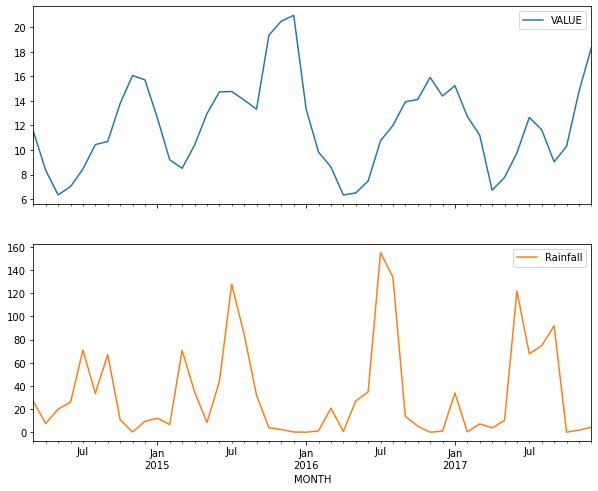

In [142]:
ABC_df_Pesticides.plot(subplots=True)

<AxesSubplot:xlabel='MONTH'>

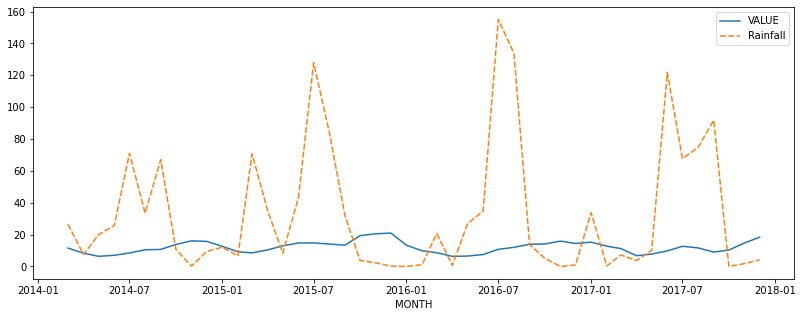

In [143]:
plt.figure(figsize = (30,5))
plt.subplot(1,2,1)
sns.lineplot(data=ABC_df_Pesticides)

In [144]:
#to find the coorelation betwween Rainfall and Value

In [145]:
col1 = ABC_df_Pesticides["Rainfall"]
col2 = ABC_df_Pesticides["VALUE"]

In [146]:
correlation = col1.corr(col2)
correlation

-0.17598310873522047

<AxesSubplot:>

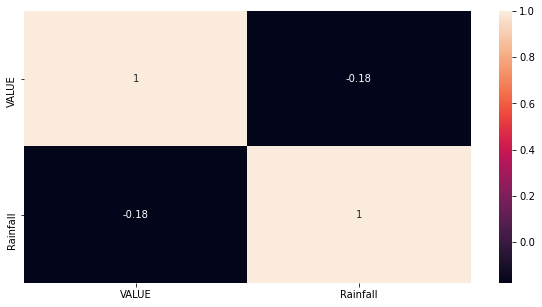

In [147]:
plt.figure(figsize = (10,5))
sns.heatmap(ABC_df_Pesticides.corr(),annot = True)